In [ ]:
# MOUNT GOOGLE DRIVE

import pandas as pd
import requests
import zipfile
import io
import os
import warnings
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')


Mounting Google Drive...
Mounted at /content/drive


In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.0 MB/s eta 0:00:00


In [ ]:
!pip install copernicusmarine -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasterio 1.5.0 requires click!=8.2.*,>=4.0, but you have click 8.2.1 which is incompatible.


In [ ]:
import copernicusmarine
help(copernicusmarine)

In [ ]:
import copernicusmarine

dataset_id = "cmems_mod_glo_phy_anfc_0.083deg_PT1H-m"

print(f" Inspecting Variables ")

try:
    catalogue = copernicusmarine.describe(dataset_id=dataset_id)

    for product in catalogue.products:
        for dataset in product.datasets:
            if dataset.dataset_id == dataset_id:
                print(f"Dataset Found: {dataset.dataset_name}\n")
                print(f"{'Short Name':<15} | {'Standard Name'}")
                print("-" * 60)
                # Correctly accessing the variables attribute from the catalogue model
                # If the model structure differs, we'll check service.variables
                for version in dataset.versions:
                    for part in version.parts:
                        for service in part.services:
                            if service.variables:
                                for var in service.variables:
                                    print(f"{var.short_name:<15} | {var.standard_name}")

except Exception as e:
    print(f" Failed to inspect: {e}")

print("\n Inspection Complete ")

In [ ]:
import copernicusmarine

dataset_id = "cmems_mod_glo_wav_anfc_0.083deg_PT3H-i"

print(f" Inspecting Variables ")

try:
    catalogue = copernicusmarine.describe(dataset_id=dataset_id)

    # find the variables list
    found = False
    for product in catalogue.products:
        for dataset in product.datasets:
            if dataset.dataset_id == dataset_id:
                print(f"Dataset Found: {dataset.dataset_name}\n")
                print(f"{'Short Name':<15} | {'Standard Name'}")
                print("-" * 60)

                # Check inside services/parts
                for version in dataset.versions:
                    for part in version.parts:
                        for service in part.services:
                            if service.variables:
                                found = True
                                for var in service.variables:
                                    print(f"{var.short_name:<15} | {var.standard_name}")

    if not found:
        print(" No variables listed in the metadata.")

except Exception as e:
    print(f" Failed to inspect: {e}")

print("\n Inspection Complete")

In [ ]:
import copernicusmarine
import xarray as xr
import os
import gc
from google.colab import drive

client = copernicusmarine.login(username=USR, password=PWD)

lon_bounds, lat_bounds = [-112, -60], [9, 52]
months = [f"{i:02d}" for i in range(1, 13)]

save_path = "/content/drive/MyDrive/AIS_Project"
if not os.path.exists(save_path):
    os.makedirs(save_path)

print("Starting ")

for month in months:
    print(f"\n Processing Month: {month}")

    try:
        # A. PHYSICS
        ds_phy = copernicusmarine.open_dataset(
            dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
            variables=["uo", "vo", "thetao"],
            start_datetime=f"2024-{month}-01T00:00:00",
            end_datetime=f"2024-{month}-28T23:59:59",
            minimum_longitude=lon_bounds[0], maximum_longitude=lon_bounds[1],
            minimum_latitude=lat_bounds[0], maximum_latitude=lat_bounds[1],
        )

        # B. WAVES
        ds_wav = copernicusmarine.open_dataset(
            dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
            variables=["VHM0", "VMDR", "VHM0_WW"],
            start_datetime=f"2024-{month}-01T00:00:00",
            end_datetime=f"2024-{month}-28T23:59:59",
            minimum_longitude=lon_bounds[0], maximum_longitude=lon_bounds[1],
            minimum_latitude=lat_bounds[0], maximum_latitude=lat_bounds[1],
        )

        # C. RENAME & INTERPOLATE
        ds_wav = ds_wav.rename({"VHM0": "swh", "VMDR": "mwd", "VHM0_WW": "wind_wave_height"})

        ds_wav_hourly = ds_wav.reindex_like(ds_phy, method="ffill")

        # D. MERGE & SAVE
        ds_final = xr.merge([ds_phy, ds_wav_hourly])

        output_file = os.path.join(save_path, f"gulf_master_2024_{month}.nc")

        comp = dict(zlib=True, complevel=5)
        encoding = {var: comp for var in ds_final.data_vars}

        # write to netcdf
        ds_final.to_netcdf(output_file, encoding=encoding)
        print("ds_final.to_netcdf(output_file, encoding=encoding) - command executed")

        # Flush to Drive
        drive.flush_and_unmount()
        drive.mount('/content/drive') # Remount for the next iteration

        print(f" SUCCESS: Saved {output_file}")

    except Exception as e:
        print(f"FAILED Month {month}: {e}")
        continue

    # CLEANUP

    try:
        ds_phy.close()
        ds_wav.close()
        ds_final.close()
    except:
        pass

    del ds_phy, ds_wav, ds_wav_hourly, ds_final
    gc.collect() # Clear RAM
    print(f" RAM Cleared for Month {month}")

print("\n Done! ")

INFO - 2026-01-30T16:24:28Z - Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.
INFO:copernicusmarine:Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.


--- 🚀 Starting Final Verified Pipeline ---

📦 Processing Month: 01


INFO - 2026-01-30T16:24:31Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2026-01-30T16:24:31Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2026-01-30T16:24:36Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2026-01-30T16:24:36Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


ds_final.to_netcdf(output_file, encoding=encoding) - command executed
Mounted at /content/drive
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_master_2024_01.nc
🧹 RAM Cleared for Month 01

📦 Processing Month: 02


INFO - 2026-01-30T16:39:08Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2026-01-30T16:39:08Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2026-01-30T16:39:13Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2026-01-30T16:39:13Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


ds_final.to_netcdf(output_file, encoding=encoding) - command executed
Mounted at /content/drive
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_master_2024_02.nc
🧹 RAM Cleared for Month 02

📦 Processing Month: 03


INFO - 2026-01-30T16:53:24Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2026-01-30T16:53:24Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2026-01-30T16:53:29Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2026-01-30T16:53:29Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


ds_final.to_netcdf(output_file, encoding=encoding) - command executed
Mounted at /content/drive
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_master_2024_03.nc
🧹 RAM Cleared for Month 03

📦 Processing Month: 04


INFO - 2026-01-30T17:08:15Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2026-01-30T17:08:15Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2026-01-30T17:08:19Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2026-01-30T17:08:20Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


In [ ]:
import copernicusmarine

# Quick inspection of the Daily Physics dataset
ds_inspect = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_glo_phy_anfc_0.083deg_P1D-m",
    start_datetime="2024-01-01T00:00:00",
    end_datetime="2024-01-02T00:00:00",
)

print("--- 🔍 DATASET INSPECTION ---")
print("Available Variables:", list(ds_inspect.data_vars))
print("-" * 30)
ds_inspect.close()

INFO - 2026-01-30T17:30:49Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2026-01-30T17:30:49Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


--- 🔍 DATASET INSPECTION ---
Available Variables: [np.str_('ist'), np.str_('mlotst'), np.str_('pbo'), np.str_('siage'), np.str_('sialb'), np.str_('siconc'), np.str_('sisnthick'), np.str_('sithick'), np.str_('sivelo'), np.str_('sob'), np.str_('tob'), np.str_('usi'), np.str_('vsi'), np.str_('zos')]
------------------------------


In [ ]:
import copernicusmarine
import xarray as xr
import pandas as pd
import os
import gc
import time
import warnings
import logging
from google.colab import drive

# CONFIGURATION
warnings.filterwarnings("ignore")
logging.getLogger("copernicusmarine").setLevel(logging.ERROR)

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive', force_remount=True)

try:
    client = copernicusmarine.login(username=USR, password=PWD)
except:
    pass

lon_bounds, lat_bounds = [-112, -60], [9, 52]
months = [f"{i:02d}" for i in range(1, 13)]
save_path = "/content/drive/MyDrive/AIS_Project"
if not os.path.exists(save_path): os.makedirs(save_path)

print("--- 🚀 Starting Final Verified Pipeline ---")

for month in months:
    month_file = os.path.join(save_path, f"gulf_daily_2024_{month}.nc")

    if os.path.exists(month_file):
        size_mb = os.path.getsize(month_file) / (1024 * 1024)
        if size_mb > 1:
            print(f"✅ Month {month} already done ({size_mb:.1f} MB). Skipping.")
            continue

    print(f"\n📦 Processing Month: 2024-{month}")
    dates = pd.date_range(start=f"2024-{month}-01", end=f"2024-{month}-28", freq='D')
    daily_datasets = []

    try:
        for i, date in enumerate(dates):
            day_str = date.strftime("%Y-%m-%d")
            print(f"   [Day {i+1}/{len(dates)}] Processing {day_str}...", end="\r")

            # PHYSICS
            ds_phy_day = copernicusmarine.open_dataset(
                dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
                variables=["uo", "vo", "thetao"],
                start_datetime=f"{day_str}T00:00:00",
                end_datetime=f"{day_str}T23:59:59",
                minimum_longitude=lon_bounds[0], maximum_longitude=lon_bounds[1],
                minimum_latitude=lat_bounds[0], maximum_latitude=lat_bounds[1],
            )
            #  MEAN:  24 hours into 1 daily average
            ds_phy_day = ds_phy_day.mean(dim="time", keep_attrs=True)

            # WAVES (3-Hourly to Daily Mean)
            ds_wav_day = copernicusmarine.open_dataset(
                dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
                variables=["VHM0", "VMDR", "VHM0_WW"],
                start_datetime=f"{day_str}T00:00:00",
                end_datetime=f"{day_str}T23:59:59",
                minimum_longitude=lon_bounds[0], maximum_longitude=lon_bounds[1],
                minimum_latitude=lat_bounds[0], maximum_latitude=lat_bounds[1],
            )
            ds_wav_day = ds_wav_day.rename({"VHM0": "swh", "VMDR": "mwd", "VHM0_WW": "wind_wave_height"})

            ds_wav_day = ds_wav_day.mean(dim="time", keep_attrs=True)

            ds_wav_day = ds_wav_day.interp_like(ds_phy_day, method="nearest")

            #  MERGE
            ds_day_merged = xr.merge([ds_phy_day, ds_wav_day])

            # Add the date stamp back
            ds_day_merged = ds_day_merged.expand_dims(time=[date])

            daily_datasets.append(ds_day_merged)

            # Cleanup
            ds_phy_day.close()
            ds_wav_day.close()
            del ds_phy_day, ds_wav_day
            gc.collect()

        #  SAVE
        print(f"\n   -> 🔄 Stacking & Saving to Drive...")
        ds_month_final = xr.concat(daily_datasets, dim="time")

        encoding = {var: dict(zlib=True, complevel=5) for var in ds_month_final.data_vars}
        ds_month_final.to_netcdf(month_file, encoding=encoding)

        os.sync()
        time.sleep(10)
        if os.path.exists(month_file):
            print(f"✅ SUCCESS: Saved {month_file} ({os.path.getsize(month_file)/1e6:.1f} MB)")

    except Exception as e:
        print(f"\n❌ CRASH: {e}")
        continue

    finally:
        if 'ds_month_final' in locals(): ds_month_final.close()
        for ds in daily_datasets: ds.close()
        del daily_datasets
        gc.collect()
        time.sleep(2)

print("\n--- 🎉 ALL DONE! ---")

File /root/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:--- 🚀 Starting Final Verified Pipeline ---

📦 Processing Month: 2024-01

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_daily_2024_01.nc (87.4 MB)

📦 Processing Month: 2024-02

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_daily_2024_02.nc (87.6 MB)

📦 Processing Month: 2024-03

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_daily_2024_03.nc (86.8 MB)

📦 Processing Month: 2024-04

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_daily_2024_04.nc (86.5 MB)

📦 Processing Month: 2024-05

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/MyDrive/AIS_Project/gulf_daily_2024_05.nc (85.2 MB)

📦 Processing Month: 2024-06

   -> 🔄 Stacking & Saving to Drive...
✅ SUCCESS: Saved /content/drive/M

In [ ]:
import os

file_path ="/content/drive/MyDrive/AIS_Project/cleaned_noaa_fleet_2024_2.csv"

df = pd.read_csv(file_path, compression='gzip')
df.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO',
       'Status', 'Length', 'Width', 'Draft', 'Cargo'],
      dtype='object')

In [ ]:
df['BaseDateTime']

,BaseDateTime
0,2024-01-01 00:00:03
1,2024-01-01 00:00:04
2,2024-01-01 00:00:00
3,2024-01-01 00:00:06
4,2024-01-01 00:00:05
...,...
2839190,2024-12-31 15:00:04
2839191,2024-12-31 15:52:35
2839192,2024-12-31 17:01:14
2839193,2024-12-31 19:56:41


In [ ]:
import pandas as pd
import xarray as xr
import os

csv_path = "/content/drive/MyDrive/AIS_Project/cleaned_noaa_fleet_2024_2.csv"
nc_pattern = "/content/drive/MyDrive/AIS_Project/gulf_daily_2024_*.nc"

#  LOAD AIS DATA
print("Attempting to decompress and read AIS data...")
try:
    # Explicitly telling pandas this is a gzipped file despite the .csv extension
    df_ais = pd.read_csv(csv_path, compression='gzip', low_memory=False)
    print(f"✅ Success! Loaded {len(df_ais)} rows.")
except Exception as e:
    print(f"❌ Gzip failed, trying standard read with error handling...")
    # Fallback: if it's NOT gzip, maybe it's just a messy CSV with bad lines
    df_ais = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')

#  THE MERGE
df_ais['BaseDateTime'] = pd.to_datetime(df_ais['BaseDateTime'])

print("Opening NetCDF files...")
ds = xr.open_mfdataset(nc_pattern, combine='by_coords')

# Prepare coordinate mapping
query_time = xr.DataArray(df_ais['BaseDateTime'], dims="z")
query_lat = xr.DataArray(df_ais['LAT'], dims="z")
query_lon = xr.DataArray(df_ais['LON'], dims="z")

print("Mapping environmental data to AIS points (nearest neighbor)...")
# Select nearest grid points
ds_points = ds.sel(
    time=query_time,
    latitude=query_lat,
    longitude=query_lon,
    method='nearest'
).load()

# Join back
df_env = ds_points.to_dataframe().reset_index()
df_final = pd.concat([df_ais.reset_index(drop=True),
                      df_env.drop(columns=['time', 'latitude', 'longitude'])], axis=1)

print(df_final.head())

Attempting to decompress and read AIS data...
✅ Success! Loaded 2839195 rows.
Opening NetCDF files...
Mapping environmental data to AIS points (nearest neighbor)...
        MMSI        BaseDateTime       LAT       LON   SOG    COG  Heading  \
0  338617000 2024-01-01 00:00:03  27.59489 -82.95020  10.7   82.8     83.0   
1  248621000 2024-01-01 00:00:04  17.18436 -67.02747   9.8   83.6     84.0   
2  538005608 2024-01-01 00:00:00  29.23282 -94.50109   7.8  308.9    308.0   
3  538004371 2024-01-01 00:00:06  41.33926 -69.39610  11.8  152.6    151.0   
4  538010185 2024-01-01 00:00:05  29.98271 -90.39640   0.0   70.7    332.0   

          IMO  Status  Length  ...  Draft  Cargo  z     depth        uo  \
0  IMO9486958     0.0   182.0  ...   10.3   80.0  0  0.494025 -0.006271   
1  IMO9527623     0.0   129.0  ...    7.1   89.0  1  0.494025 -0.250535   
2  IMO9704465     0.0   182.0  ...   10.9   80.0  2  0.494025 -0.101908   
3  IMO9482562     0.0   183.0  ...    8.7   80.0  3  0.494025  0.0

In [ ]:
df_final

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,IMO,Status,Length,...,Draft,Cargo,z,depth,uo,vo,thetao,swh,mwd,wind_wave_height
0,338617000,2024-01-01 00:00:03,27.59489,-82.95020,10.7,82.8,83.0,IMO9486958,0.0,182.0,...,10.3,80.0,0,0.494025,-0.006271,0.054438,17.574572,0.49625,267.924998,0.03000
1,248621000,2024-01-01 00:00:04,17.18436,-67.02747,9.8,83.6,84.0,IMO9527623,0.0,129.0,...,7.1,89.0,1,0.494025,-0.250535,-0.098760,27.803492,1.09000,67.993753,0.68500
2,538005608,2024-01-01 00:00:00,29.23282,-94.50109,7.8,308.9,308.0,IMO9704465,0.0,182.0,...,10.9,80.0,2,0.494025,-0.101908,-0.072885,14.665118,0.50125,202.216250,0.11375
3,538004371,2024-01-01 00:00:06,41.33926,-69.39610,11.8,152.6,151.0,IMO9482562,0.0,183.0,...,8.7,80.0,3,0.494025,0.033838,-0.126997,7.937023,1.26750,236.628749,0.55125
4,538010185,2024-01-01 00:00:05,29.98271,-90.39640,0.0,70.7,332.0,IMO9593012,5.0,274.0,...,9.3,80.0,4,0.494025,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839190,205736000,2024-12-31 15:00:04,22.53630,-96.85989,13.5,187.8,189.0,IMO9719290,0.0,180.0,...,9.5,89.0,2839190,0.494025,0.098773,0.332384,26.135988,1.01250,113.482501,0.56750
2839191,351434000,2024-12-31 15:52:35,22.80716,-90.54648,9.0,88.4,89.0,IMO9347736,0.0,120.0,...,7.6,80.0,2839191,0.494025,-0.057532,0.037958,25.173674,0.85500,88.302502,0.37375
2839192,248669000,2024-12-31 17:01:14,26.95370,-92.57848,12.8,184.9,188.0,IMO9795127,0.0,277.0,...,10.4,80.0,2839192,0.494025,0.093499,0.072091,25.090019,1.25500,142.362501,0.63875
2839193,215307000,2024-12-31 19:56:41,27.33674,-88.50904,10.2,333.3,329.0,IMO9382750,0.0,249.0,...,9.1,89.0,2839193,0.494025,0.433545,-0.084980,24.515350,1.50125,128.393751,0.77125


In [ ]:
df_final.isnull().sum()

,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
IMO,0
Status,0
Length,0


In [ ]:
# Group by MMSI to see the data quality per ship
ship_stats = df_final.groupby('MMSI').agg(
    total_rows=('BaseDateTime', 'count'),
    null_rows=('uo', lambda x: x.isnull().sum())
).reset_index()

# Calculate the percentage of missing data per ship
ship_stats['null_percentage'] = (ship_stats['null_rows'] / ship_stats['total_rows']) * 100

# Sort by the most problematic ships
ship_stats = ship_stats.sort_values(by='null_percentage', ascending=False)

print("--- Ship-wise Data Quality Summary ---")
print(ship_stats.head(20))

# Optional: See how many ships are "completely lost" (100% nulls)
completely_null = ship_stats[ship_stats['null_percentage'] == 100].shape[0]
print(f"\nShips with 100% missing environmental data: {completely_null}")

--- Ship-wise Data Quality Summary ---
           MMSI  total_rows  null_rows  null_percentage
757   316012308        1516       1516            100.0
752   316003880        4531       4531            100.0
753   316003980         256        256            100.0
767   316033265        1108       1108            100.0
765   316031772        2037       2037            100.0
762   316015050        5837       5837            100.0
772   316041032        2428       2428            100.0
775   316053441        6225       6225            100.0
769   316037373         160        160            100.0
770   316037697         560        560            100.0
773   316050854        7071       7071            100.0
759   316013209        7299       7299            100.0
760   316013215        7381       7381            100.0
950   367353660        8728       8728            100.0
507   255984000         296        296            100.0
776   316055401        2568       2568            100.0
1493  538

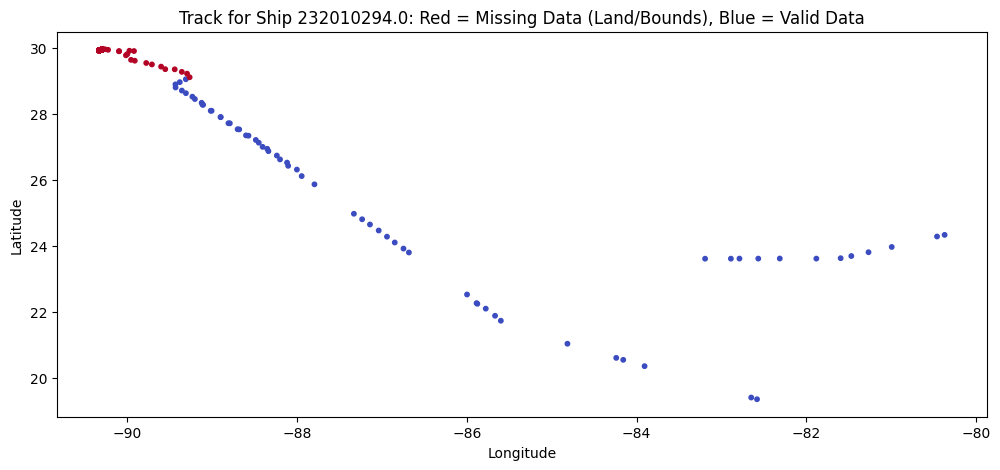

In [ ]:
import matplotlib.pyplot as plt

# Pick an MMSI with partial data
example_mmsi = ship_stats[ship_stats['null_percentage'] < 90].iloc[0]['MMSI']
test_ship = df_final[df_final['MMSI'] == example_mmsi]

plt.figure(figsize=(12, 5))
plt.scatter(test_ship['LON'], test_ship['LAT'], c=test_ship['uo'].isnull(), cmap='coolwarm', s=10)
plt.title(f"Track for Ship {example_mmsi}: Red = Missing Data (Land/Bounds), Blue = Valid Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# using uo as the primary indicator for missing environmental data
ship_null_stats = df_final.groupby('MMSI').agg(
    total_pings=('BaseDateTime', 'count'),
    null_pings=('uo', lambda x: x.isnull().sum())
).reset_index()

# CALCULATE PERCENTAGE
ship_null_stats['null_percentage'] = (ship_null_stats['null_pings'] / ship_null_stats['total_pings']) * 100

#  FILTER: 1% TO 100% MISSING
# Using > 0.0 to catch everything from a single null to total failure
ships_with_gaps = ship_null_stats[ship_null_stats['null_percentage'] > 0].copy()

# Sort by percentage so you see the 100% "Landlocked" ships at the top
ships_with_gaps = ships_with_gaps.sort_values(by='null_percentage', ascending=False)


print(f"Found {len(ships_with_gaps)} ships with at least some missing environmental data.")
print(ships_with_gaps.head(50)) # Showing the top 50 to start

Found 2145 ships with at least some missing environmental data.
           MMSI  total_pings  null_pings  null_percentage
752   316003880         4531        4531       100.000000
753   316003980          256         256       100.000000
759   316013209         7299        7299       100.000000
762   316015050         5837        5837       100.000000
757   316012308         1516        1516       100.000000
760   316013215         7381        7381       100.000000
772   316041032         2428        2428       100.000000
769   316037373          160         160       100.000000
770   316037697          560         560       100.000000
767   316033265         1108        1108       100.000000
765   316031772         2037        2037       100.000000
776   316055401         2568        2568       100.000000
773   316050854         7071        7071       100.000000
775   316053441         6225        6225       100.000000
204   231875000         1033        1033       100.000000
1493  53

In [ ]:
# IDENTIFY SHIPS WITH ZERO NULLS
perfect_ships = ship_null_stats[ship_null_stats['null_pings'] == 0].copy()

#  DISPLAY COUNT AND SAMPLES
print(f"--- 🌊 The 'Open Sea' Fleet ---")
print(f"Number of ships with 0% missing data: {len(perfect_ships)}")
print(f"\nSample of perfect ships (MMSI and ping count):")
print(perfect_ships.head(20))

#  COMPARE TO TOTAL
total_ships = len(ship_null_stats)
perfect_pct = (len(perfect_ships) / total_ships) * 100
print(f"\nSummary: {perfect_pct:.2f}% of your fleet has a perfect environmental match.")

--- 🌊 The 'Open Sea' Fleet ---
Number of ships with 0% missing data: 161

Sample of perfect ships (MMSI and ping count):
          MMSI  total_pings  null_pings  null_percentage
6    205761000          733           0              0.0
22   215018000         1179           0              0.0
34   215532000          126           0              0.0
44   215668000           59           0              0.0
54   215810000          178           0              0.0
60   215888000          151           0              0.0
79   219029411          470           0              0.0
98   219242000          124           0              0.0
146  228059600          519           0              0.0
170  229070000          123           0              0.0
172  229083000          119           0              0.0
174  229189000          281           0              0.0
175  229248000          220           0              0.0
197  229754000          371           0              0.0
200  229858000          

--- 📊 Ship Distribution by Missing Data Percentage ---
null_range
0-10%      292
10-20%     333
20-30%     505
30-40%     444
40-50%     352
50-60%     200
60-70%      83
70-80%      45
80-90%      17
90-100%     35
Name: count, dtype: int64


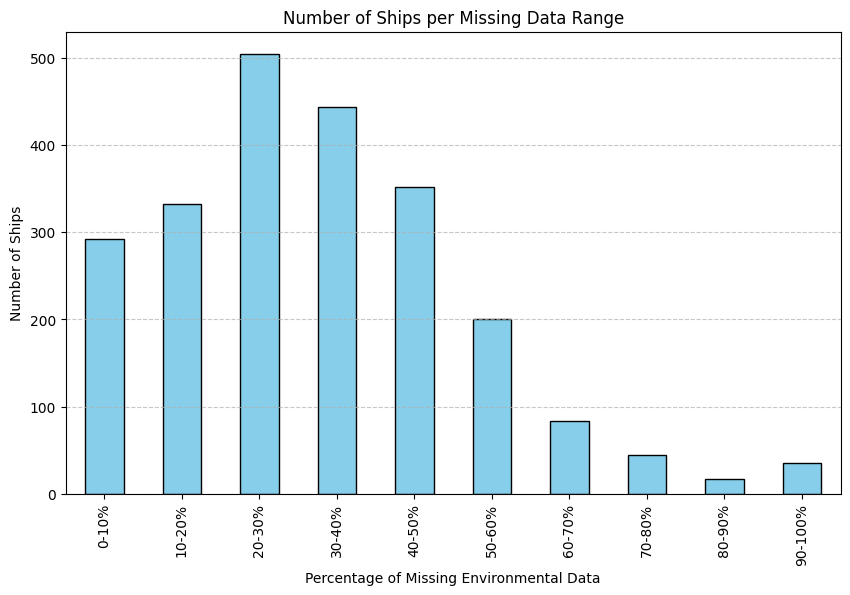

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#  DEFINE BINS
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

#  CATEGORIZE SHIPS
# We use the 'ship_null_stats' dataframe we created earlier
# We use include_lowest=True to catch the 0% and 100% cases correctly
ship_null_stats['null_range'] = pd.cut(ship_null_stats['null_percentage'], bins=bins, labels=labels, include_lowest=True)

#  COUNT SHIPS PER RANGE
range_counts = ship_null_stats['null_range'].value_counts().sort_index()

#  DISPLAY TABLE
print("--- 📊 Ship Distribution by Missing Data Percentage ---")
print(range_counts)

#  VISUALIZE
plt.figure(figsize=(10, 6))
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Ships per Missing Data Range')
plt.xlabel('Percentage of Missing Environmental Data')
plt.ylabel('Number of Ships')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
!pip install contextily geopandas

In [ ]:
import geopandas as gpd

print("Preparing geospatial data for plotting...")
gdf_plot = df_final.copy()

gdf_plot['is_null'] = gdf_plot['uo'].isnull().astype(str)
gdf_plot['MMSI_STR'] = gdf_plot['MMSI'].astype(str)

gdf_plot = gdf_plot.rename(columns={'LON': 'lon', 'LAT': 'lat'})

print(f"gdf_plot defined with {len(gdf_plot)} rows.")

In [ ]:
!pip install geoviews cartopy holoviews --quiet
print("Installation complete")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.7/574.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.5 MB/s eta 0:00:00
Installation complete


In [ ]:
!pip install  bokeh  --quiet
!pip install jupyter_bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
missing_col = 'uo'
print("Calculating data stats per ship...")

# Group by MMSI and calculate counts
ship_null_stats = df_final.groupby('MMSI').apply(
    lambda x: pd.Series({
        'MMSI': x['MMSI'].iloc[0],
        'total_pings': len(x),
        'null_pings': x[missing_col].isna().sum(),
        'null_percentage': (x[missing_col].isna().sum() / len(x)) * 100
    })
).reset_index(drop=True)

#  Sort for easier viewing
ship_null_stats = ship_null_stats.sort_values(by='null_percentage', ascending=False)

print(ship_null_stats.head())

Calculating data stats per ship...
            MMSI  total_pings  null_pings  null_percentage
757  316012308.0       1516.0      1516.0            100.0
752  316003880.0       4531.0      4531.0            100.0
753  316003980.0        256.0       256.0            100.0
767  316033265.0       1108.0      1108.0            100.0
765  316031772.0       2037.0      2037.0            100.0


/tmp/ipython-input-1754564657.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ship_null_stats = df_final.groupby('MMSI').apply(


In [ ]:
#  IDENTIFY SHIPS WITH 20 to 20.5 % nulls
ten_percent_ships = ship_null_stats[
    (ship_null_stats['null_percentage'] < 20.5) & (ship_null_stats['null_percentage'] > 20)
].copy()

#  DISPLAY COUNT AND SAMPLES
print(f" The '20-20.5% Gap' Fleet ")
print(f"Number of ships with ~21% missing data: {len(ten_percent_ships)}")

if len(ten_percent_ships) > 0:
    print(f"\nSample of filtered ships (MMSI and ping count):")
    # Using 'null_percentage' in the print so you can verify the filter worked
    print(ten_percent_ships[['MMSI', 'total_pings', 'null_pings', 'null_percentage']].head(20))
else:
    print("\nNo ships found in the 20-20.5% range. Try widening the range if needed.")

#  COMPARE TO TOTAL
total_ships = len(ship_null_stats)
range_pct_of_total = (len(ten_percent_ships) / total_ships) * 100
print(f"\nSummary: {range_pct_of_total:.2f}% of your fleet falls in this missing data range.")

 The '20-20.5% Gap' Fleet 
Number of ships with ~21% missing data: 17

Sample of filtered ships (MMSI and ping count):
             MMSI  total_pings  null_pings  null_percentage
2099  636020078.0       1008.0       206.0        20.436508
1260  538004981.0        509.0       104.0        20.432220
104   219314000.0        749.0       153.0        20.427236
408   248531000.0       3070.0       627.0        20.423453
1067  414476000.0       1338.0       273.0        20.403587
313   241593000.0       2866.0       583.0        20.341940
1088  477010100.0        935.0       190.0        20.320856
2166  636021228.0       1059.0       215.0        20.302172
1075  419001909.0       1212.0       246.0        20.297030
1986  636017141.0       1578.0       320.0        20.278834
464   249948000.0       2052.0       416.0        20.272904
2061  636019204.0        449.0        91.0        20.267261
384   247284500.0        431.0        87.0        20.185615
1904  636014278.0       2467.0       497.

✅ Found 19 ships. Generating map...


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
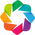

:HoloMap   [Vessel MMSI]
   :Overlay
      .WMTS.I          :WMTS   [Longitude,Latitude]
      .Points.I        :Points   [Longitude,Latitude]   (MMSI_STR,SOG,BaseDateTime,uo,thetao)
      .Points.CCS_Hubs :Points   [lon,lat]   (name)
      .Labels.I        :Labels   [lon,lat]   (name)

In [ ]:
from IPython.display import display

missing_stats = df_final.groupby('MMSI')[['uo', 'vo', 'thetao']].apply(
    lambda x: x.isna().any(axis=1).sum() / len(x) * 100
)

target_mmsis = missing_stats[
    (missing_stats >= 20.0) &
    (missing_stats <= 20.5)
].index.tolist()

print(f"✅ Found {len(target_mmsis)} ships. Generating map...")
hv.extension('bokeh')

if len(target_mmsis) > 0:
    display(interactive_map)
else:
    print("No ships found in range.")

Filtering for rows with missing environmental data
Fetching high-res coastline data (this downloads ~5MB)...
Projecting to EPSG:5070 (meters) for accurate calculation...
Merging coastline segments...
Calculating distance for 1001629 points... (this may take a few seconds)


/tmp/ipython-input-3741481778.py:52: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coast_union = gdf_coast_meters.geometry.unary_union



--- DISTANCE ANALYSIS (Missing Data Points) ---
count    1.001629e+06
mean     4.880375e+01
std      1.391526e+02
min      1.461647e-05
25%      8.099193e-01
50%      4.796266e+00
75%      1.535724e+01
max      1.013583e+03
Name: dist_to_coast_km, dtype: float64

Number of missing points within 10km of coast: 601053 (60.0%)


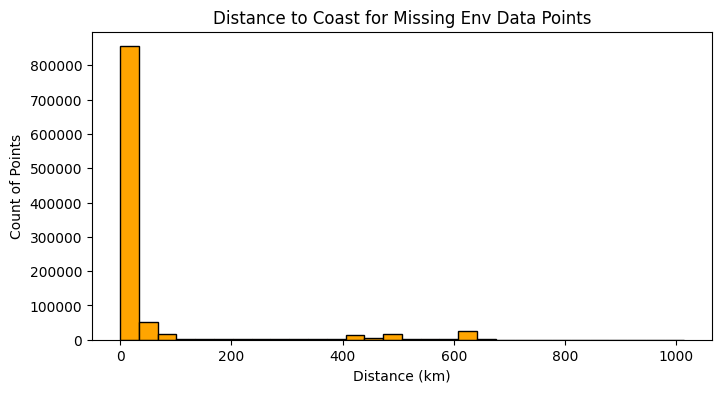

In [ ]:
import geopandas as gpd
from shapely.ops import unary_union

#  PREPARE MISSING DATA
print("Filtering for rows with missing environmental data")
# filtering where 'uo' is NaN
missing_mask = df_final['uo'].isna()
df_missing = df_final[missing_mask].copy()

if df_missing.empty:
    print("No missing data found")
else:
    # Convert to GeoDataFrame
    gdf_missing = gpd.GeoDataFrame(
        df_missing,
        geometry=gpd.points_from_xy(df_missing.LON, df_missing.LAT),
        crs="EPSG:4326"  # WGS84 (Lat/Lon)
    )

    #  GET COASTLINE DATA
    # We download the 10m physical coastline from Natural Earth
    # This is much more accurate than the default 'lowres' map
    coast_url = "https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip"
    print("Fetching high-res coastline data (this downloads ~5MB)...")
    try:
        gdf_coast = gpd.read_file(coast_url)
    except Exception as e:
        print(f"Download failed: {e}. Falling back to low-res built-in map.")
        gdf_coast = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # 3. OPTIMIZE (Clip the coast)
    # We add a 1-degree buffer around your ships to be safe.
    bounds = gdf_missing.total_bounds # [minx, miny, maxx, maxy]
    bbox_buffer = 1.0

    # spatial index filtering (cx) is fast
    gdf_coast_clipped = gdf_coast.cx[
        bounds[0]-bbox_buffer : bounds[2]+bbox_buffer,
        bounds[1]-bbox_buffer : bounds[3]+bbox_buffer
    ]

    #  PROJECT TO METERS (CRITICAL STEP)
    # EPSG:5070 is great for the Gulf of Mexico/USA (preserves distance well)
    target_crs = "EPSG:5070"

    print("Projecting to EPSG:5070 (meters) for accurate calculation...")
    gdf_missing_meters = gdf_missing.to_crs(target_crs)
    gdf_coast_meters = gdf_coast_clipped.to_crs(target_crs)

    # Combine all coast segments into one single shape for easy math
    print("Merging coastline segments...")
    coast_union = gdf_coast_meters.geometry.unary_union

    #  CALCULATE DISTANCE
    print(f"Calculating distance for {len(gdf_missing)} points... (this may take a few seconds)")
    # .distance calculates nearest distance to the geometry
    # Result is in meters, so we divide by 1000 for km
    gdf_missing['dist_to_coast_km'] = gdf_missing_meters.geometry.distance(coast_union) / 1000

    #  RESULTS
    print("\n--- DISTANCE ANALYSIS (Missing Data Points) ---")
    print(gdf_missing['dist_to_coast_km'].describe())

    # Check how many are effectively "On Land" or in "Ports"
    near_coast = (gdf_missing['dist_to_coast_km'] < 10).sum()
    print(f"\nNumber of missing points within 10km of coast: {near_coast} ({(near_coast/len(gdf_missing))*100:.1f}%)")

    # Quick histogram to see the distribution
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,4))
        plt.hist(gdf_missing['dist_to_coast_km'], bins=30, color='orange', edgecolor='black')
        plt.title('Distance to Coast for Missing Env Data Points')
        plt.xlabel('Distance (km)')
        plt.ylabel('Count of Points')
        plt.show()
    except:
        pass

In [ ]:
df_final.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO',
       'Status', 'Length', 'Width', 'Draft', 'Cargo', 'z', 'depth', 'uo', 'vo',
       'thetao', 'swh', 'mwd', 'wind_wave_height'],
      dtype='object')

uo (Eastward Seawater Velocity): The speed of the ocean current moving East (+) or West (-) in meters per second.

vo (Northward Seawater Velocity): The speed of the ocean current moving North (+) or South (-) in meters per second.

thetao (Sea Water Potential Temperature): The temperature of the seawater in degrees Celsius (°C).

swh (Significant Wave Height): The average height (in meters) of the highest one-third of all waves, representing what a human observer sees.

mwd (Mean Wave Direction): The direction (0-360°) that the waves are coming from.

wind_wave_height (Wind Wave Height): The specific height (in meters) of waves generated by local winds (surface chop), excluding distant swells.

In [ ]:
#  60% missing data are because they are too near the coast, filling with still water values
#  interpolate from nearby ships/grid point for those far from the coast

import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator

print("Starting process")

if 'dist_to_coast_km' not in df_final.columns:
    print(" 'dist_to_coast_km' missing from df_final. Mapping it ")

    # Initialize column with NaN
    df_final['dist_to_coast_km'] = np.nan

    # Check if gdf_missing exists in memory (from your distance calc step)
    if 'gdf_missing' in locals():
        # Map the values using the index
        df_final.loc[gdf_missing.index, 'dist_to_coast_km'] = gdf_missing['dist_to_coast_km']
        print(f" Successfully mapped distances for {len(gdf_missing)} rows.")
    else:
        raise ValueError(" ERROR: 'gdf_missing' not found.")


# Coastal
coastal_idx = df_final[
    (df_final['uo'].isna()) & (df_final['dist_to_coast_km'] < 10)
].index

# Deep Water
deep_idx = df_final[
    (df_final['uo'].isna()) & (df_final['dist_to_coast_km'] >= 10)
].index

print(f"Deep Water Gaps to fill (KNN): {len(deep_idx)}")
print(f"Coastal Gaps to zero (Port):   {len(coastal_idx)}")

# FILL COASTAL
cols_to_zero = ['uo', 'vo', 'swh', 'wind_wave_height', 'mwd']
existing_zero_cols = [c for c in cols_to_zero if c in df_final.columns]
df_final.loc[coastal_idx, existing_zero_cols] = 0.0

#  FILL DEEP WATER (Nearest Neighbor Interpolation)
if len(deep_idx) > 0:
    print("Looking up nearest values for deep water gaps...")

    # The columns we need to copy
    targets = ['uo', 'vo', 'thetao', 'swh', 'mwd', 'wind_wave_height']
    target_cols = [t for t in targets if t in df_final.columns]

    # We drop NaNs to get a clean reference map
    valid_data = df_final.dropna(subset=['uo'])

    # Optimization: Sample 200k points to prevent RAM explosion
    if len(valid_data) > 200000:
        valid_data = valid_data.sample(200000, random_state=42)

    # Coordinates
    points_valid = valid_data[['LON', 'LAT']].values
    points_missing = df_final.loc[deep_idx, ['LON', 'LAT']].values

    # Loop to lookup values
    for col in target_cols:
        print(f" -> Filling {col}...")
        interpolator = NearestNDInterpolator(points_valid, valid_data[col].values)
        df_final.loc[deep_idx, col] = interpolator(points_missing)

#  FILL COASTAL TEMPERATURE
if 'thetao' in df_final.columns:
    coastal_temp_nans = df_final.loc[coastal_idx, 'thetao'].isna()

    if coastal_temp_nans.any():
        print(" -> Interpolating temperature for coastal/port areas (avoiding 0°C)...")
        # Reuse valid points from above
        interpolator = NearestNDInterpolator(points_valid, valid_data['thetao'].values)

        # Find indices specifically for coastal temp gaps
        fill_indices = df_final.loc[coastal_idx][coastal_temp_nans].index
        fill_coords = df_final.loc[fill_indices, ['LON', 'LAT']].values

        df_final.loc[fill_indices, 'thetao'] = interpolator(fill_coords)

print("✅ All gaps filled.")

Starting process
 'dist_to_coast_km' missing from df_final. Mapping it 
 Successfully mapped distances for 1001629 rows.
Deep Water Gaps to fill (KNN): 400576
Coastal Gaps to zero (Port):   601053
Looking up nearest values for deep water gaps...
 -> Filling uo...
 -> Filling vo...
 -> Filling thetao...
 -> Filling swh...
 -> Filling mwd...
 -> Filling wind_wave_height...
 -> Interpolating temperature for coastal/port areas (avoiding 0°C)...
✅ All gaps filled.


In [ ]:
df_final.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,IMO,Status,Length,...,Cargo,z,depth,uo,vo,thetao,swh,mwd,wind_wave_height,dist_to_coast_km
0,338617000,2024-01-01 00:00:03,27.59489,-82.95020,10.7,82.8,83.0,IMO9486958,0.0,182.0,...,80.0,0,0.494025,-0.006271,0.054438,17.574572,0.49625,267.924998,0.03000,NaN
1,248621000,2024-01-01 00:00:04,17.18436,-67.02747,9.8,83.6,84.0,IMO9527623,0.0,129.0,...,89.0,1,0.494025,-0.250535,-0.098760,27.803492,1.09000,67.993753,0.68500,NaN
2,538005608,2024-01-01 00:00:00,29.23282,-94.50109,7.8,308.9,308.0,IMO9704465,0.0,182.0,...,80.0,2,0.494025,-0.101908,-0.072885,14.665118,0.50125,202.216250,0.11375,NaN
3,538004371,2024-01-01 00:00:06,41.33926,-69.39610,11.8,152.6,151.0,IMO9482562,0.0,183.0,...,80.0,3,0.494025,0.033838,-0.126997,7.937023,1.26750,236.628749,0.55125,NaN
4,538010185,2024-01-01 00:00:05,29.98271,-90.39640,0.0,70.7,332.0,IMO9593012,5.0,274.0,...,80.0,4,0.494025,0.000000,0.000000,NaN,0.00000,0.000000,0.00000,10.64472


In [ ]:
df_final.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO',
       'Status', 'Length', 'Width', 'Draft', 'Cargo', 'z', 'depth', 'uo', 'vo',
       'thetao', 'swh', 'mwd', 'wind_wave_height', 'dist_to_coast_km'],
      dtype='object')

In [ ]:
df_final.isnull().sum()

,0
MMSI,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
IMO,0
Status,0
Length,0


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator

print("cleaning remaining nullvalues")

# Columns that still have issues
problem_cols = ['thetao', 'swh', 'mwd', 'wind_wave_height']

for col in problem_cols:
    missing_idx = df_final[df_final[col].isna()].index

    #  Get Valid Data
    valid_data = df_final.dropna(subset=[col])
    if len(valid_data) > 100000:
        valid_data = valid_data.sample(100000, random_state=42)
    points_valid = valid_data[['LON', 'LAT']].values
    values_valid = valid_data[col].values

    try:
        interpolator = NearestNDInterpolator(points_valid, values_valid)
        points_missing = df_final.loc[missing_idx, ['LON', 'LAT']].values
        filled_values = interpolator(points_missing)
        df_final.loc[missing_idx, col] = filled_values
        print(f"  Filled {col} successfully.")

    except Exception as e:
        print(f"   Failed to fill {col}: {e}")


print("\FINAL NULL CHECK ")
null_counts = df_final[['uo', 'vo', 'thetao', 'swh', 'mwd']].isna().sum()
print(null_counts)

<>:40: SyntaxWarning: invalid escape sequence '\F'
<>:40: SyntaxWarning: invalid escape sequence '\F'
/tmp/ipython-input-2576678009.py:40: SyntaxWarning: invalid escape sequence '\F'
  print("\FINAL NULL CHECK ")


cleaning remaining nullvalues
  Filled thetao successfully.
  Filled swh successfully.
  Filled mwd successfully.
  Filled wind_wave_height successfully.
\FINAL NULL CHECK 
uo        0
vo        0
thetao    0
swh       0
mwd       0
dtype: int64


In [ ]:
df_final.drop(columns=['dist_to_coast_km'], inplace=True)
print(df_final.columns)

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO',
       'Status', 'Length', 'Width', 'Draft', 'Cargo', 'z', 'depth', 'uo', 'vo',
       'thetao', 'swh', 'mwd', 'wind_wave_height'],
      dtype='object')


In [ ]:
df_final.drop(columns=['z','depth'], inplace=True)
print(df_final.columns)

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO',
       'Status', 'Length', 'Width', 'Draft', 'Cargo', 'uo', 'vo', 'thetao',
       'swh', 'mwd', 'wind_wave_height'],
      dtype='object')


In [ ]:
# --- 7. SAVE ---
folder_path = "/content/drive/MyDrive/AIS_Project"
output_file = os.path.join(folder_path, "merged_ais_ocean_2024.csv")
df_final.to_csv(output_file, index=False)

In [ ]:
file_path="/content/drive/MyDrive/AIS_Project/merged_ais_ocean_2024.csv"
df_final=pd.read_csv(file_path)

Status column is usually when captain or somebody sets the value. sometimes they forget so not reliable.

In [ ]:
print(" MMSI vs. IMO ")

# Filter out zeros
clean_data = df_final[(df_final['IMO'] != 0) & (df_final['IMO'].notna())]

#  physical ship (IMO) change its Radio ID (MMSI)?
imo_groups = clean_data.groupby('IMO')['MMSI'].nunique()
unstable_imos = imo_groups[imo_groups > 1]

print(f"1. Ships (IMOs) that used multiple MMSIs: {len(unstable_imos)}")

# Radio ID (MMSI) report different IMOs?
mmsi_groups = clean_data.groupby('MMSI')['IMO'].nunique()
unstable_mmsis = mmsi_groups[mmsi_groups > 1]

print(f"2. Radio IDs (MMSIs) that reported conflicting IMOs: {len(unstable_mmsis)}")

# RESULT
if len(unstable_imos) > len(unstable_mmsis):
    print("IMO is more stable")
else:
    print(" MMSI is more stable")

 MMSI vs. IMO 
1. Ships (IMOs) that used multiple MMSIs: 27
2. Radio IDs (MMSIs) that reported conflicting IMOs: 0
IMO is more stable


In [ ]:
# drop mmsi column
df_final.drop(columns=['MMSI'], inplace=True)
print(df_final.columns)

Index(['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO', 'Status',
       'Length', 'Width', 'Draft', 'Cargo', 'uo', 'vo', 'thetao', 'swh', 'mwd',
       'wind_wave_height'],
      dtype='object')


In [ ]:
df_final['Status'].value_counts()

,count
Status,
0.0,1140157
1.0,878993
5.0,759151
3.0,38926
2.0,6730
9.0,6719
8.0,4912
15.0,2737
4.0,706


Transit - 0, 8 - Used to calculate fuel burn and travel time between capture and storage sites.

Port/Stationary - 1, 5 - Crucial for "Turnaround Time" (TAT) and loading/unloading efficiency metrics.

Maneuvering - 2, 3, 7 - High-risk/Low-speed zones; essential for safety variables in Monte Carlo simulations.

Too heavy - 4 - high payloadd indicator or speed restrictions

Outliers /Noise - 9, 15, 13, 12, 6

In [ ]:
codes_remove = [9.0, 15.0, 13.0, 12.0, 6.0]

size_before = len(df_final)

df_final = df_final[~df_final['Status'].isin(codes_remove)]

size_after = len(df_final)
print(f"Remaining data: {size_after} rows.")

Remaining data: 2829580 rows.


In [ ]:
df_final['Cargo'].value_counts()

,count
Cargo,
80.0,2046940
89.0,389160
82.0,161005
81.0,109021
84.0,78134
83.0,36572
85.0,9453
88.0,8355
86.0,487


Type 80 (Tanker - Generic): A general vessel designed to transport liquids or gases in bulk.

Type 81 (Tanker - Hazard A): Carrying major hazardous materials (highest danger level) posing significant threat to life or environment.

Type 82 (Tanker - Hazard B): Carrying hazardous materials deemed dangerous to the environment or safety.

Type 83 (Tanker - Hazard C): Carrying hazardous materials presenting a minor danger to the environment or safety.

Type 84 (Tanker - Hazard D): Carrying recognizable hazardous materials with a low probability of causing major damage.

Type 85-88 (Tanker - Reserved): Codes reserved for future use or specific regional assignments.

Type 89 (Tanker - No Info): A tanker vessel where the specific cargo hazard level is not defined or currently available.

In [ ]:
len(df_final)

2839195

In [ ]:
# Count unique VesselTypes per MMSI
# We group by ship (MMSI) and ask: "How many unique labels do you have?"
type_counts = df_final.groupby('IMO')['Cargo'].nunique()

#filter for these
confused_ships = type_counts[type_counts > 1]

print(f"Found {len(confused_ships)} ships with conflicting Vessel Types.")

#  Display
if len(confused_ships) > 0:
    print("\n--- Ships with Multiple Identities ---")
    inconsistent_data = df_final[df_final['IMO'].isin(confused_ships.index)]
    print(inconsistent_data.groupby('IMO')['Cargo'].unique())
else:
    print(" All ships have a consistent Vessel Type.")

Found 319 ships with conflicting Vessel Types.

--- Ships with Multiple Identities ---
IMO
IMO9034729    [83.0, 80.0]
IMO9047518    [80.0, 82.0]
IMO9047764    [82.0, 80.0]
IMO9102083    [85.0, 81.0]
IMO9102100    [82.0, 80.0]
                  ...     
IMO9952127    [82.0, 83.0]
IMO9956410    [82.0, 80.0]
IMO9958004    [82.0, 80.0]
IMO9961192    [85.0, 89.0]
IMO9965552    [89.0, 82.0]
Name: Cargo, Length: 319, dtype: object


In [ ]:
#ANALYZING THE "TYPE 89"

# 1. Get the list of unique types per ship again
ship_profiles = df_final.groupby('IMO')['Cargo'].unique()

# 2. Filter: Find ships that have '89' in their list AND have more than 1 type
# logic: (89 is in the list) AND (length of list > 1)
type_89_switchers = ship_profiles[
    ship_profiles.apply(lambda types: 89.0 in types and len(types) > 1)
]

print(f"Found {len(type_89_switchers)} ships that toggled to/from Type 89.")


print("\n--- The Secret Identities of Type 89 Ships ---")
print(type_89_switchers.head(10))


print("\n--- Most Common 89 Switches ---")
print(type_89_switchers.astype(str).value_counts().head())

Found 181 ships that toggled to/from Type 89.

--- The Secret Identities of Type 89 Ships ---
IMO
IMO9103403                [89.0, 80.0]
IMO9114232          [82.0, 89.0, 83.0]
IMO9114244          [89.0, 82.0, 84.0]
IMO9118628                [89.0, 82.0]
IMO9168611    [82.0, 80.0, 83.0, 89.0]
IMO9168623          [89.0, 82.0, 80.0]
IMO9168635    [82.0, 80.0, 81.0, 89.0]
IMO9172210                [89.0, 82.0]
IMO9173070                [89.0, 80.0]
IMO9214317                [80.0, 89.0]
Name: Cargo, dtype: object

--- Most Common 89 Switches ---
Cargo
[89. 80.]    51
[80. 89.]    39
[89. 82.]    16
[82. 89.]    12
[81. 89.]     6
Name: count, dtype: int64


Relavent Cargo(Vessel types) are 80,81,84 and 89

In [ ]:

print(f"Original Fleet Size (Rows): {len(df_final)}")
print(f"Original Unique Ships: {df_final['IMO'].nunique()}")

# strictly use the codes : 80 (Generic), 81 (Hazard A), 84 (Hazard D)
target_types = [80, 81, 84]

#  look for any ship that has EVER used one of these codes.
relevant_mmsis = df_final.loc[df_final['Cargo'].isin(target_types), 'IMO'].unique()

print(f"\nShips found that have toggled to {target_types} at least once: {len(relevant_mmsis)}")

#  keep only the rows belonging to these specific ships
df_cleaned = df_final[df_final['IMO'].isin(relevant_mmsis)].copy()

dropped_ships = df_final['IMO'].nunique() - len(relevant_mmsis)
dropped_rows = len(df_final) - len(df_cleaned)

print(f"Dropped {dropped_ships} irrelevant ships ")
print(f"Dropped {dropped_rows} rows of data.")
print(f"New Fleet Size (Rows): {len(df_cleaned)}")

Original Fleet Size (Rows): 2829580
Original Unique Ships: 2266

Ships found that have toggled to [80, 81, 84] at least once: 1890
Dropped 376 irrelevant ships 
Dropped 407199 rows of data.
New Fleet Size (Rows): 2422381


In [ ]:
# Update the main dataframe
df_final = df_cleaned

#  Check what Vessel Types are left in the dataset
print("\nRemaining Vessel Types in dataset :")
print(df_final['Cargo'].unique())


Remaining Vessel Types in dataset :
[80. 85. 89. 81. 82. 84. 88. 83. 86.]


In [ ]:
df_final['Cargo'].value_counts()

,count
Cargo,
80.0,2046940
81.0,109021
89.0,105077
84.0,78134
82.0,68627
83.0,12243
88.0,6503
85.0,4637
86.0,409


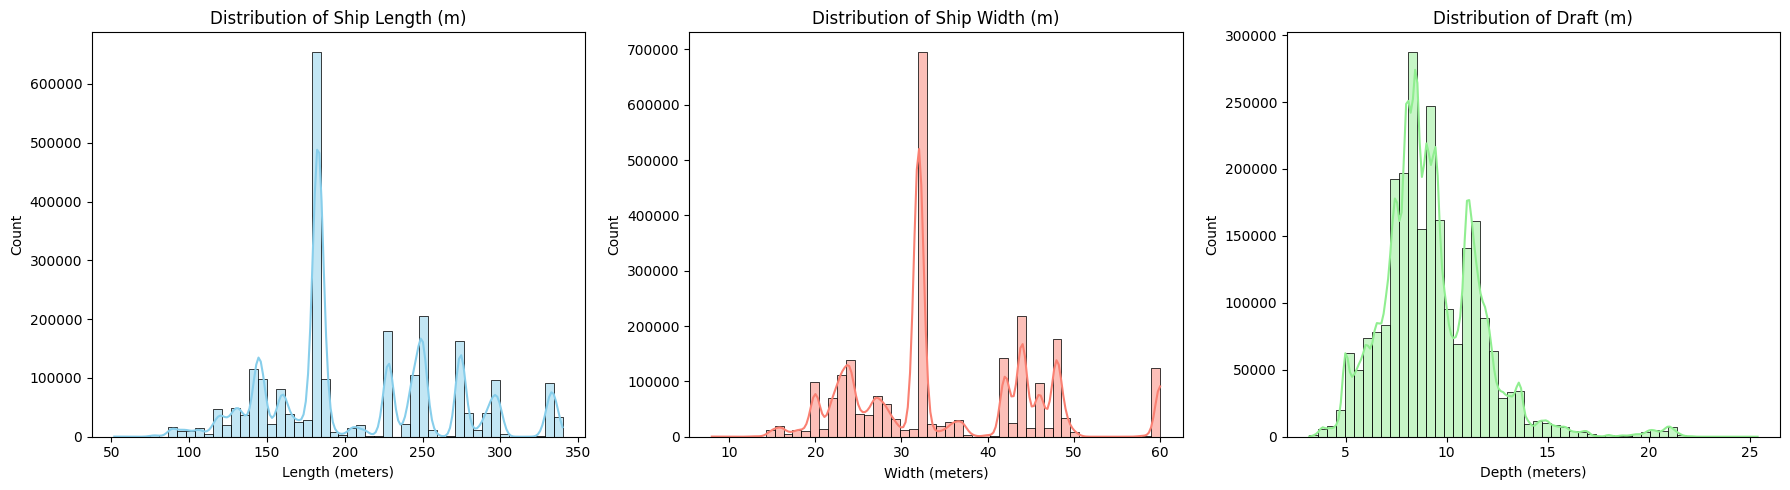

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-muted')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Length Distribution
sns.histplot(df_final['Length'], bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Ship Length (m)')
axes[0].set_xlabel('Length (meters)')

# 2. Width Distribution
sns.histplot(df_final['Width'], bins=50, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Ship Width (m)')
axes[1].set_xlabel('Width (meters)')

# 3. Draft Distribution
draft_col = 'Draft'
sns.histplot(df_final[draft_col], bins=50, ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title(f'Distribution of {draft_col} (m)')
axes[2].set_xlabel('Depth (meters)')

plt.tight_layout()
plt.show()

In [ ]:
df_final.describe()

,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo,uo,vo,thetao,swh,mwd,wind_wave_height
count,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06
mean,2.956549e+01,-8.822497e+01,4.070567e+00,1.885802e+02,1.665406e+02,1.702890e+00,2.079717e+02,3.496551e+01,9.266125e+00,8.066820e+01,1.069796e-02,3.331272e-02,2.211239e+01,6.465314e-01,8.476644e+01,3.264180e-01
std,5.313995e+00,9.053139e+00,5.762808e+00,1.003803e+02,9.960923e+01,2.075264e+00,5.790173e+01,1.059363e+01,2.480005e+00,2.002946e+00,2.007174e-01,2.198152e-01,7.648510e+00,6.518545e-01,7.501349e+01,4.403001e-01
min,1.013595e+01,-1.114868e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.200000e+01,8.000000e+00,3.200000e+00,8.000000e+01,-1.587012e+00,-1.969445e+00,1.361836e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.779498e+01,-9.469348e+01,0.000000e+00,1.100000e+02,8.600000e+01,0.000000e+00,1.760000e+02,2.700000e+01,7.800000e+00,8.000000e+01,-6.409591e-02,-2.729805e-02,1.722440e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.920887e+01,-9.347365e+01,1.000000e-01,1.878000e+02,1.550000e+02,1.000000e+00,1.830000e+02,3.200000e+01,8.900000e+00,8.000000e+01,0.000000e+00,0.000000e+00,2.435981e+01,5.575000e-01,9.509625e+01,1.537500e-01
75%,2.989045e+01,-8.084835e+01,1.040000e+01,2.728000e+02,2.510000e+02,5.000000e+00,2.500000e+02,4.400000e+01,1.090000e+01,8.000000e+01,1.438895e-02,2.165456e-02,2.862426e+01,1.063750e+00,1.413738e+02,5.037500e-01
max,5.222548e+01,-6.000038e+01,4.000000e+01,3.600000e+02,3.590000e+02,8.000000e+00,3.400000e+02,6.000000e+01,2.540000e+01,8.900000e+01,2.266420e+00,2.163174e+00,3.331586e+01,6.598750e+00,3.588637e+02,5.761250e+00


In [ ]:
import numpy as np

def get_drift_angle(heading, cog):
    diff = heading - cog
    drift = (diff + 180) % 360 - 180
    return drift

# Apply to dataframe
df_final['drift_angle'] = df_final.apply(
    lambda x: get_drift_angle(x['Heading'], x['COG']), axis=1
)

In [ ]:
df_final.columns

Index(['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'IMO', 'Status',
       'Length', 'Width', 'Draft', 'Cargo', 'uo', 'vo', 'thetao', 'swh', 'mwd',
       'wind_wave_height', 'drift_angle'],
      dtype='object')

In [ ]:
df_final.isnull().sum()

,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
COG,0
Heading,0
IMO,0
Status,0
Length,0
Width,0


In [ ]:
df_final.describe()

,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo,uo,vo,thetao,swh,mwd,wind_wave_height,drift_angle
count,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06,2.422381e+06
mean,2.956549e+01,-8.822497e+01,4.070567e+00,1.885802e+02,1.665406e+02,1.702890e+00,2.079717e+02,3.496551e+01,9.266125e+00,8.066820e+01,1.069796e-02,3.331272e-02,2.211239e+01,6.465314e-01,8.476644e+01,3.264180e-01,-1.558357e+00
std,5.313995e+00,9.053139e+00,5.762808e+00,1.003803e+02,9.960923e+01,2.075264e+00,5.790173e+01,1.059363e+01,2.480005e+00,2.002946e+00,2.007174e-01,2.198152e-01,7.648510e+00,6.518545e-01,7.501349e+01,4.403001e-01,8.151240e+01
min,1.013595e+01,-1.114868e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.200000e+01,8.000000e+00,3.200000e+00,8.000000e+01,-1.587012e+00,-1.969445e+00,1.361836e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.800000e+02
25%,2.779498e+01,-9.469348e+01,0.000000e+00,1.100000e+02,8.600000e+01,0.000000e+00,1.760000e+02,2.700000e+01,7.800000e+00,8.000000e+01,-6.409591e-02,-2.729805e-02,1.722440e+01,0.000000e+00,0.000000e+00,0.000000e+00,-5.400000e+01
50%,2.920887e+01,-9.347365e+01,1.000000e-01,1.878000e+02,1.550000e+02,1.000000e+00,1.830000e+02,3.200000e+01,8.900000e+00,8.000000e+01,0.000000e+00,0.000000e+00,2.435981e+01,5.575000e-01,9.509625e+01,1.537500e-01,-2.000000e-01
75%,2.989045e+01,-8.084835e+01,1.040000e+01,2.728000e+02,2.510000e+02,5.000000e+00,2.500000e+02,4.400000e+01,1.090000e+01,8.000000e+01,1.438895e-02,2.165456e-02,2.862426e+01,1.063750e+00,1.413738e+02,5.037500e-01,4.600000e+01
max,5.222548e+01,-6.000038e+01,4.000000e+01,3.600000e+02,3.590000e+02,8.000000e+00,3.400000e+02,6.000000e+01,2.540000e+01,8.900000e+01,2.266420e+00,2.163174e+00,3.331586e+01,6.598750e+00,3.588637e+02,5.761250e+00,1.799000e+02


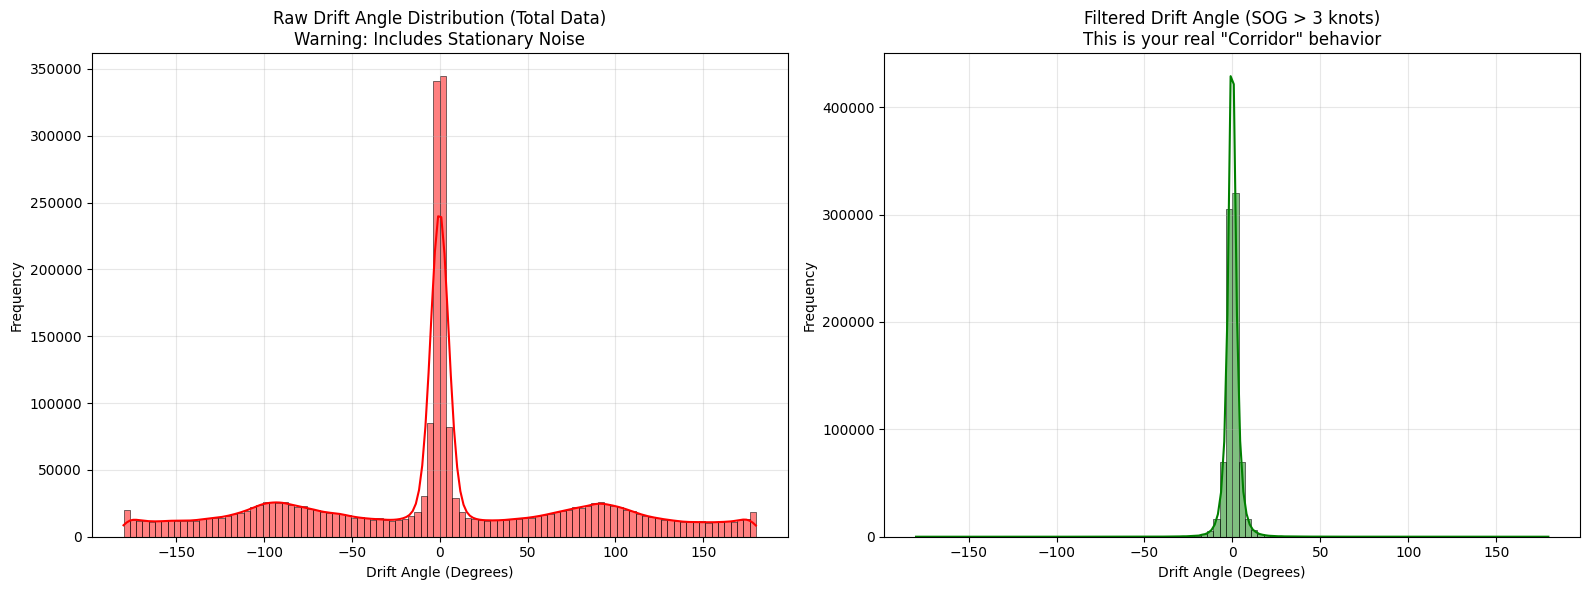

In [ ]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram of the RAW Drift Angle
sns.histplot(df_final['drift_angle'], bins=100, kde=True, ax=ax1, color='red')
ax1.set_title('Raw Drift Angle Distribution (Total Data)\nWarning: Includes Stationary Noise')
ax1.set_xlabel('Drift Angle (Degrees)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Filtered Distribution
transit_df = df_final[df_final['SOG'] > 3.0]

sns.histplot(transit_df['drift_angle'], bins=100, kde=True, ax=ax2, color='green')
ax2.set_title('Filtered Drift Angle (SOG > 3 knots)\nThis is your real "Corridor" behavior')
ax2.set_xlabel('Drift Angle (Degrees)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


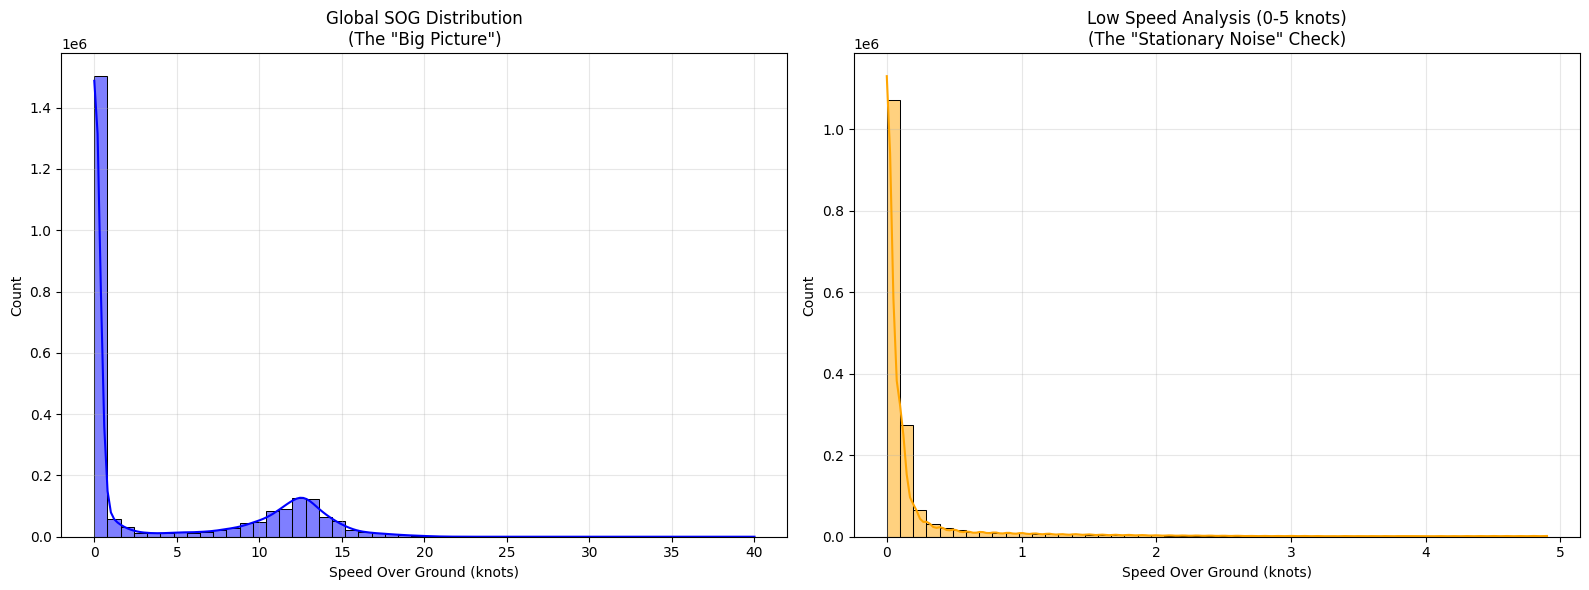

Total Rows: 2422381
Rows with SOG < 1 knot (Essentially Stopped): 1521171 (62.8%)
Rows with SOG > 1 knot (Moving): 901210


In [ ]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Full Distribution
sns.histplot(df_final['SOG'], bins=50, kde=True, ax=ax1, color='blue')
ax1.set_title('Global SOG Distribution\n(The "Big Picture")')
ax1.set_xlabel('Speed Over Ground (knots)')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)

# 2.low speed behaviour
sns.histplot(df_final[df_final['SOG'] < 5]['SOG'], bins=50, kde=True, ax=ax2, color='orange')
ax2.set_title('Low Speed Analysis (0-5 knots)\n(The "Stationary Noise" Check)')
ax2.set_xlabel('Speed Over Ground (knots)')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(f"Total Rows: {len(df_final)}")
print(f"Rows with SOG < 1 knot (Essentially Stopped): {len(df_final[df_final['SOG'] < 1])} ({len(df_final[df_final['SOG'] < 1])/len(df_final)*100:.1f}%)")
print(f"Rows with SOG > 1 knot (Moving): {len(df_final[df_final['SOG'] >= 1])}")

In [ ]:
# removing still ships
df_still_removed = df_final[df_final['SOG'] >=1].copy()

rows_dropped_sog = len(df_final) - len(df_still_removed)
print(f" Dropped {rows_dropped_sog:,} rows where SOG < 1 knots.")

 Dropped 1,521,171 rows where SOG < 1 knots.


In [ ]:
len(df_final)

2422381

In [ ]:
len(df_still_removed)

901210

In [ ]:
df_still_removed.describe()

,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo,uo,vo,thetao,swh,mwd,wind_wave_height,drift_angle
count,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000,901210.000000
mean,28.206008,-85.305960,10.834097,189.838353,184.383945,0.105668,210.963795,35.420577,9.588330,80.656669,0.068891,0.106866,24.155799,0.999125,108.267903,0.504614,-0.748734
std,5.755738,9.318943,4.047605,103.506694,103.043526,0.702972,58.311532,10.571946,2.614468,1.961814,0.298655,0.331740,6.780457,0.686132,67.517246,0.519534,20.873062
min,10.169950,-111.486840,1.000000,0.000000,0.000000,0.000000,52.000000,8.000000,3.200000,80.000000,-1.587012,-1.969445,1.361836,0.000000,0.000000,0.000000,-180.000000
25%,25.095050,-93.943678,9.300000,103.200000,98.000000,0.000000,180.000000,27.000000,8.000000,80.000000,-0.079386,-0.034997,22.129501,0.532500,69.023752,0.097500,-2.100000
50%,27.737665,-88.099830,11.900000,186.800000,181.000000,0.000000,184.000000,32.000000,9.200000,80.000000,0.000000,0.008297,26.382003,0.947500,109.688752,0.365000,-0.100000
75%,29.343800,-79.389582,13.300000,283.300000,277.000000,0.000000,250.000000,44.000000,11.100000,80.000000,0.129881,0.170890,29.109526,1.403750,145.150938,0.748750,1.900000
max,52.225480,-60.000380,40.000000,360.000000,359.000000,8.000000,340.000000,60.000000,24.000000,89.000000,2.266420,2.163174,33.315860,6.598750,358.863746,5.761250,179.900000


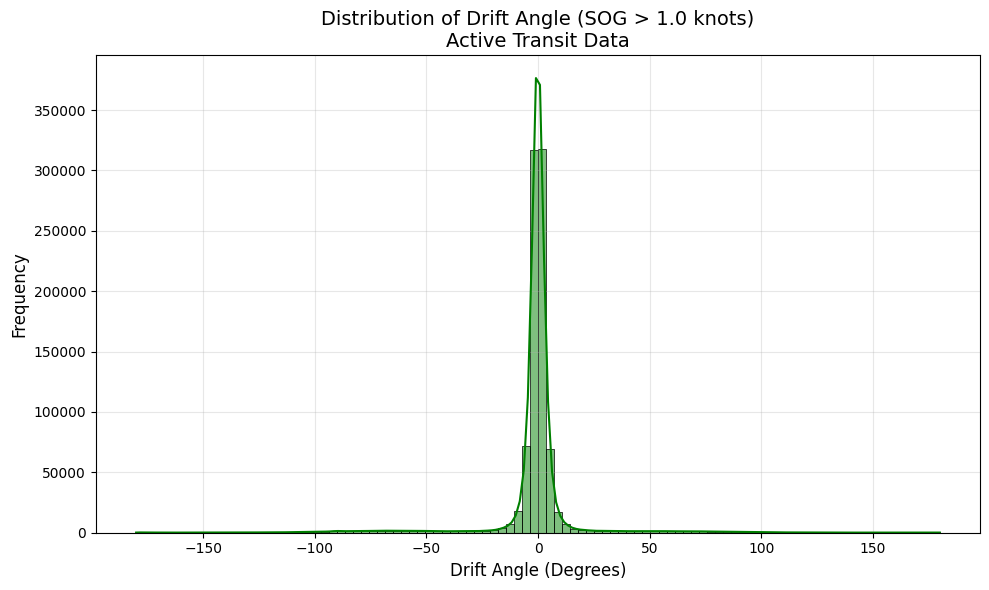

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_still_removed['drift_angle'], bins=100, kde=True, color='green')
plt.title('Distribution of Drift Angle (SOG > 1.0 knots)\nActive Transit Data', fontsize=14)
plt.xlabel('Drift Angle (Degrees)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
lower_limit = -50
upper_limit = 50

in_range_raw = df_still_removed[(df_still_removed['drift_angle'] >= lower_limit) & (df_still_removed['drift_angle'] <= upper_limit)]
count_raw = len(in_range_raw)
pct_raw = (count_raw / len(df_still_removed)) * 100

print(f"Rows between {lower_limit} and {upper_limit} deg: {count_raw:,}")
print(f"Percentage of total: {pct_raw:.1f}%")

Rows between -50 and 50 deg: 858,676
Percentage of total: 95.3%


In [ ]:
initial_len = len(df_still_removed)
df_still_removed = df_still_removed[df_still_removed['drift_angle'].abs() <= 50.0]

rows_dropped_drift = initial_len - len(df_still_removed)
print(f"[Step 2] Dropped {rows_dropped_drift:,} rows with Drift Angle > 50 degrees.")

[Step 2] Dropped 42,534 rows with Drift Angle > 50 degrees.


In [ ]:
df_still_removed.describe()

,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo,uo,vo,thetao,swh,mwd,wind_wave_height,drift_angle
count,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000,858676.000000
mean,28.310050,-85.237338,11.292108,187.785654,185.235881,0.085690,210.172448,35.265067,9.585836,80.656145,0.074570,0.109173,24.098577,0.982292,108.026894,0.491549,-0.045173
std,5.775100,9.226498,3.567517,103.465559,103.282159,0.652568,58.028117,10.486563,2.611662,1.958986,0.299708,0.334500,6.850224,0.681385,67.992225,0.511091,7.071534
min,10.206030,-111.486840,1.000000,0.000000,0.000000,0.000000,52.000000,8.000000,3.200000,80.000000,-1.587012,-1.969445,1.361836,0.000000,0.000000,0.000000,-50.000000
25%,25.136610,-93.861742,9.900000,101.800000,99.000000,0.000000,180.000000,27.000000,8.000000,80.000000,-0.074176,-0.033806,22.017123,0.521250,68.091253,0.091250,-2.000000
50%,27.765855,-87.823190,12.000000,183.600000,182.000000,0.000000,183.000000,32.000000,9.200000,80.000000,0.000000,0.008435,26.364258,0.928750,109.547502,0.352500,-0.100000
75%,29.373240,-79.400955,13.400000,282.000000,279.000000,0.000000,250.000000,44.000000,11.100000,80.000000,0.134854,0.174290,29.128074,1.383750,145.550001,0.728750,1.800000
max,52.225480,-60.000380,38.400000,360.000000,359.000000,8.000000,340.000000,60.000000,24.000000,89.000000,2.266420,2.163174,33.315860,6.598750,358.863746,5.761250,50.000000


In [ ]:
df_still_removed['IMO'].nunique()

1884

In [ ]:
df_still_removed['IMO'].value_counts()

,count
IMO,
IMO9564578,4604
IMO9077044,4189
IMO9353527,4070
IMO9748007,3950
IMO9762352,3884
...,...
IMO9441178,17
IMO9302023,16
IMO9642942,11


In [ ]:
# SAVE
folder_path = "/content/drive/MyDrive/AIS_Project"
output_file = os.path.join(folder_path, "merged_ais_ocean_2024_reduced.csv")
df_still_removed.to_csv(output_file, index=False)